<h1><center>Physique numérique (PHY-3500) - Projet final</center></h1>
<h2><center>Compression d'images avec pertes</center></h2>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [1]:
from __future__ import annotations

from typing import Optional
from functools import partial

import numpy as np
import pandas as pd
import skimage as ski
from numba import njit
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Métriques de performance [1]

Afin de discuter de la performance des algorithmes de compression qui seront implémentés, il est nécessaire d'établir une méthode de mesure pouvant quantifier la différence entre l'image originale et l'image décompressée. Dans ce projet, il question d'implémenter des méthodes de compression avec pertes, c'est-à-dire que des données seront volontairement supprimées afin d'en réduire la taille. Les méthodes traditionnelles tels que l'erreur quadratique moyenne (MSE) et le PSNR (*Peak Signal to Noise Ratio*) permettent de mesurer le degré de différence entre deux images, mais, comme leur approche de calcul repose sur les différences absolues, elles s'avèrent incompatible avec la perception visuelle humaine en pratique. Sachant que la compression avec pertes encourage l'altération des données basée sur des changements imperceptibles par l'œil, le calcul des différences dans la qualité des images doit être sensible aux changements visuellement perceptibles. À ce titre, l'algorithme MSSIM (*Mean Structural Similarity Index Measure*) est une métrique utilisée pour mesurer la similarité entre deux images de cette manière.

### Concept de base et formulation mathématique

Le MSSIM est basé sur l'observation que les pixels ont de fortes interdépendances, surtout lorsqu'ils sont spatialement proches. Ces interdépendances portent des informations importantes sur la structure de l'objet dans l'espace visuel. L'indice MSSIM prend en compte les changements de luminance, de contraste et de structure des images. Le MSSIM entre deux fenêtres d'images $x$ et $y$ de taille commune $N \times N$ est défini comme suit :

$$\text{SSIM}(x,\ y) = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)} \ ,$$

où:
- $\mu_x$ et $\mu_y$ sont les moyennes de $x$ et $y$,
- $\sigma_x^2$ et $\sigma_y^2$ sont les variances de $x$ et $y$,
- $\sigma_{xy}$ est la covariance entre $x$ et $y$,
- $c_1 = (k_1L)^2$ et $c_2 = (k_2L)^2$ sont deux variables pour stabiliser la division avec un petit dénominateur,
  - $L$ est la plage dynamique des valeurs de pixel (généralement $L = 2^n-1$ où $n$ est le nombre de bits par pixel),
  - $k_1 = 0.01$ et $k_2 = 0.03$ sont des constantes par défaut.

Le MSSIM sur l'ensemble de l'image est le calcul moyen des indices SSIM sur différentes fenêtres de l'image. Cela permet d'obtenir une mesure globale de la qualité sur diverses parties de l'image.

$$\text{MSSIM}(x,\ y) = \frac{1}{M} \sum_{i=1}^M \text{SSIM}(x_i, y_i) \ ,$$

où $M$ est le nombre total de fenêtres locales dans l'image. L'indice MSSIM est donc une mesure puissante pour évaluer la similitude structurelle entre deux images. Il est sensible aux changements perceptibles par l'œil humain, ce qui le rend particulièrement utile pour des applications où la qualité visuelle est critique.

In [2]:
def get_metrics(img1: NDArray, img2: NDArray) -> int | float:
    """Calcule le SSIM (Structural Similarity Index Measure) entre deux images.

    Paramètres
    ----------
        img1
            Première image pour la comparaison.
        img2
            Seconde image pour la comparaison.

    Retourne
    --------
        ssim
            Le SSIM entre les deux images en pourcentage.

    """
    grayscale = img1.ndim == 2
    drange = 1 if img1.dtype.kind == 'f' or img2.dtype.kind == 'f' else 255

    kwargs = dict(data_range=drange)
    if not grayscale:
        kwargs['channel_axis'] = -1

    ssim = ski.metrics.structural_similarity(img1, img2, **kwargs) * 100
    return ssim


def add_noise(image, noise_type="gaussian", **params):
    """Ajoute du bruit spécifié à une image en niveaux de gris ou en couleur.

    Paramètres
    ----------
        image
            L'image d'entrée sur laquelle ajouter du bruit. Peut être en
            niveaux de gris ou RGB.
        noise_type
            Type de bruit à ajouter. Les options incluent "gaussian" (gaussien),
            "salt_pepper" (sel et poivre), "poisson" (Poisson), et
            "uniform" (uniforme).
        **params
            Paramètres additionnels pour configurer le bruit :
                - "mean" et "std" pour le bruit gaussien.
                - "qty" et "salt_vs_pepper" pour le bruit sel et poivre.
                - "scale" pour le bruit Poisson.
                - "low" et "high" pour le bruit uniforme.

    Retourne
    --------
        noisy_img
            L'image avec le bruit appliqué, retournée en tant que tableau NumPy.

    Soulève
    -------
        ValueError
            Si le type de bruit spécifié n'est pas pris en charge.

    """
    if noise_type == "gaussian":
        mean = params.pop("mean", 0)
        std = params.pop("std", 0.1)
        noise = np.random.normal(mean, std, image.shape)

    elif noise_type == "salt_pepper":
        qty = params.pop("qty", 0.05)
        s_vs_p = params.pop("salt_vs_pepper", 0.5)
        n_salt = np.ceil(qty * s_vs_p * image.size).astype(int)
        n_pepper = np.ceil(qty * (1 - s_vs_p) * image.size).astype(int)

        # Création du bruit
        noisy_img = image.copy()
        salt_coords = np.unravel_index(
            np.random.choice(
                image.size,
                n_salt,
                replace=False,
            ),
            image.shape
        )
        pepper_coords = np.unravel_index(
            np.random.choice(
                image.size,
                n_pepper,
                replace=False,
            ),
            image.shape,
        )
        noisy_img[salt_coords] = 255
        noisy_img[pepper_coords] = 0

    elif noise_type == "poisson":
        scale = params.pop("scale", 1)
        noise = np.random.poisson(image * scale) / scale

    elif noise_type == "uniform":
        low = params.pop("low", -10)
        high = params.pop("high", 10)
        noise = np.random.uniform(low, high, image.shape)

    else:
        raise ValueError(
            "Type de bruit non pris en charge. Choisissez 'gaussian'",
            "'salt_pepper', 'poisson', ou 'uniform'.",
        )

    if noise_type != "salt_pepper":
        noisy_img = image + noise

    # Clip et convertit en uint8 pour la visualisation matplotlib
    noisy_img.clip(0, 255, out=noisy_img).astype(np.uint8, copy=False)
    return noisy_img


def read_file(path: str, grayscale: bool = False):
    """Lit une image à partir d'un chemin de fichier.

    Paramètres
    ----------
        path
            Chemin vers le fichier image à lire.
        grayscale
            Si True, convertit l'image en niveaux de gris.

    Retourne
    --------
        img
            L'image en couleur ou en niveaux de gris selon
            le paramètre 'grayscale'.

    """
    img = ski.io.imread(path)
    if img.ndim > 2 and grayscale is True:
        gray_img = ski.color.rgb2gray(img)
        return img, gray_img
    return img


def get_memory(im: NDArray, mb: bool = True) -> int | float:
    """Calcule la mémoire utilisée par une image en méga-octets ou en octets.

    Paramètres
    ----------
        im
            L'image dont la mémoire doit être calculée.
        mb
            Si True, renvoie la mémoire en méga-bits. Sinon, bits.

    Retourne
    --------
        mem
            La mémoire utilisée par l'image en méga-bits ou en bits.

    """
    mem = 8 * im.nbytes
    if mb is True:
        mem *= 1e-6
    return mem

# Images de référence

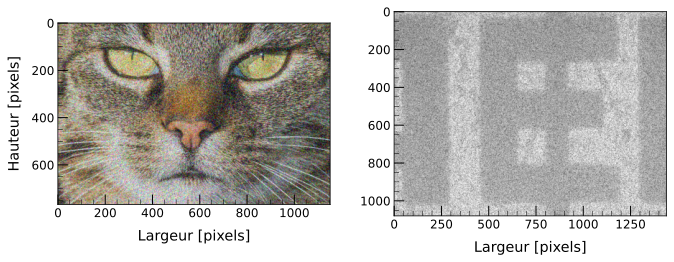

In [3]:
img_m = read_file("single21.tif")
img, gray_img = read_file("cat.tiff", grayscale=True)
M, N = img.shape[:2]

# Ajout de bruit pour tester la robustesse
img = add_noise(img, "salt_pepper", qty=0.4, s_vs_p=0.8)
img_m = add_noise(img_m, "salt_pepper", qty=0.4, s_vs_p=0.8)
init_mem = get_memory(img)
init_mem_m = get_memory(img_m)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(img)
ax1.set_xlabel("Largeur [pixels]")
ax1.set_ylabel("Hauteur [pixels]")
ax2.imshow(img_m, cmap="gray")
ax2.set_xlabel("Largeur [pixels]")
plt.tight_layout(pad=3)
plt.show()

# Méthode de la Transformée Cosinus Discrète (DCT) [2]

La DCT aide à concentrer l'information d'image dans un petit nombre de coefficients fréquentiels. Ceci est particulièrement utile pour les images naturelles où la majorité de l'énergie spectrale est concentrée dans les basses fréquences. La DCT transforme un bloc de pixels en un ensemble de coefficients qui représentent l'intensité et la fréquence des variations de couleur ou de luminosité à travers le bloc.

#### Équation de la DCT

Pour un bloc d'image de taille $N \times N$, la DCT est définie par l'équation suivante pour chaque coefficient $C(u, v)$:

$$C(u, v) = \alpha(u) \alpha(v) \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} f(x, y) \cos \left[\frac{(2x+1)u\pi}{2N}\right] \cos \left[\frac{(2y+1)v\pi}{2N}\right] \ ,$$

où:
- $f(x, y)$ est l'intensité du pixel à la position $(x, y)$,
- $u, v$ sont les indices des fréquences en horizontal et vertical,
- $\alpha(u)$ et $\alpha(v)$ sont des facteurs d'échelle définis par:

$$
\alpha(u) = \begin{cases} 
\sqrt{\frac{1}{N}} & \text{si } u = 0 \\
\sqrt{\frac{2}{N}} & \text{autrement}
\end{cases}
$$

Taux de compression : 0.10
Taille des données initiales: 21.234 MB
Taille des données compressées: 2.123 MB
Coefficient de similitude structurale de référence : 57.716%


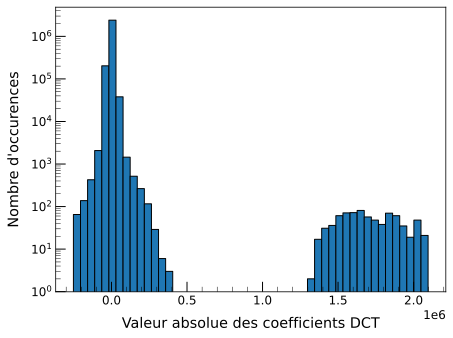

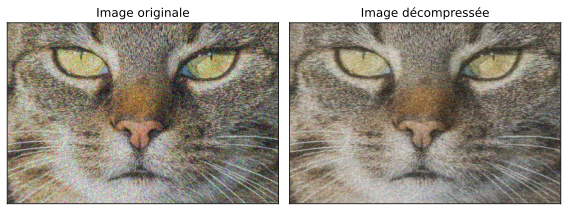

In [4]:
def dct2(y: NDArray) -> NDArray:
    """Calcule la DCT bidimensionnelle d'un tableau.

    Gère automatiquement les canaux multiples par vectorisation.

    Paramètres
    ----------
        y
            Tableau bidimensionnel représentant l'image dont il faut
            calculer les coefficients DCT.

    Retourne
    --------
        c
            Tableau bidimensionnel représentant les coefficients DCT
            de l'iamge.

    """
    shape = y.shape
    M, N = shape[-2], shape[-1]
    assert y.ndim >= 2, "L'array d'entrée doit avoir au moins 2 dimensions."

    # Extension et symétrie pour chaque ligne
    y2 = np.empty(shape[:-1] + (2 * N,))
    y2[..., :N] = y
    y2[..., N:] = np.flip(y, axis=-1)

    # Calculer la DCT sur chaque ligne
    c = np.fft.rfft(y2, axis=-1)
    c = c[..., :N] * np.exp(-1j * np.pi * np.arange(N) / (2 * N))[None]

    # Extension et symétrie pour chaque colonne
    y2 = np.empty(shape[:-2] + (2 * M, N))
    y2[..., :M, :] = c.real
    y2[..., M:, :] = np.flip(c.real, axis=-2)

    # Calculer la DCT sur colonne via la transposition
    c = np.fft.rfft(y2, axis=-2)
    phi = np.exp(-1j * np.pi * np.arange(M) / (2 * M))[:, None]
    c = c[..., :M, :] * phi
    return c.real


def idct2(b: NDArray) -> NDArray:
    """Calcule la IDCT bidimensionnelle d'un tableau.

    Gère automatiquement les canaux multiples par vectorisation.

    Paramètres
    ----------
        b
            Tableau bidimensionnel représentant les coefficients DCT
            à transformer.

    Retourne
    --------
        y
            Tableau bidimensionnel représentant l'image transformée
            par IDCT2.

    """
    M, N = b.shape[-2], b.shape[-1]
    assert b.ndim >= 2, "L'array d'entrée doit avoir au moins 2 dimensions."

    # Calculer la IDCT sur colonne via la transposition
    c = np.empty(b.shape[:-1] + (N + 1,), dtype=np.complex64)
    c[..., :N] = np.exp(1j * np.pi * np.arange(N) / (2 * N))[None] * b
    c[..., N] = 0
    a = np.fft.irfft(c, axis=-1)[..., :N]

    # Calculer l'IDCT sur les colonnes en transposant les deux dernières dimensions
    # Nécessite d'échanger puis de rééchanger les deux dernières dimensions
    b = a.swapaxes(-1, -2)
    c = np.empty(b.shape[:-1] + (M + 1,), dtype=np.complex64)
    c[..., :M] = np.exp(1j * np.pi * np.arange(M) / (2 * M))[None] * b
    c[..., M] = 0
    y = np.fft.irfft(c, axis=-1)[..., :M]

    # Rétablir les dimensions
    y = y.swapaxes(-1, -2)
    return y


def dct_compressor(
    img: NDArray,
    ratio: float = 0.1,
    reverse: bool = False,
    debug: bool = False,
) -> NDArray:
    """Compression d'image via la méthode DCT.

    Paramètres
    ----------
        image
            Image d'entrée.
        ratio
            Valeur de seuil pour la compression. Par défaut : 0.1.
        reverse
            Décompresse l'image d'entrée si vrai, sinon compresse l'image.
            Active la compression par défaut.
        debug
            Si vrai, le compresseur retourne également les coefficients DCT
            et le ratio de compression calculé d'après la quantité de donnée
            restante à des fins de vérification.

    Retourne
    --------
        decompr_fft
            Image de transformée de Fourier décompressée.
        compr_fft_mag
            Amplitude de l'image de transformée de Fourier compressée.
        compr_ratio
            Taux de compression.

    """
    image = img.copy()
    if reverse is False:
        assert ratio is not None and ratio > 0

        # Calcul du seuil basé sur le quantile
        dct_img = dct2(image)
        seuil = np.quantile(np.abs(dct_img), 1 - ratio)

        # Tronquer les coefficients de fréquence les moins significatifs
        sig = np.abs(dct_img) > seuil
        cimg = dct_img * sig
        if debug is True:
            cratio = sig.sum() / dct_img.size
            return cimg, dct_img, cratio
        return cimg

    else:
        # Décompression de l'image
        dcimg = idct2(img)

        # Image de sortie 8 bits
        dcimg = dcimg.clip(0, 255).astype(np.uint8)
        return dcimg


# Compression, déompression de l'image et score de similitude
cimg, dct_img, cratio = dct_compressor(img, 0.1, debug=True)
dcimg = dct_compressor(cimg, reverse=True)
cimg_vis = np.clip(cimg, 0, 255).astype(np.uint8)
ssim = get_metrics(img, dcimg)

print(f"Taux de compression : {cratio:.2f}")
print(f"Taille des données initiales: {init_mem:.3f} MB")
print(f"Taille des données compressées: {cratio * init_mem:.3f} MB")
print(f"Coefficient de similitude structurale de référence : {ssim:.3f}%")

# Histogramme des valeurs absolues des coefficients DCT
plt.hist(dct_img.ravel(), bins=50, log=True, edgecolor="k")
plt.xlabel("Valeur absolue des coefficients DCT")
plt.ylabel("Nombre d'occurences")
plt.show()

# Visualisation des résultats
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Image originale")
axes[1].imshow(dcimg, cmap="gray")
axes[1].set_title("Image décompressée")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(which="both", direction="out")

plt.show()

# Compression par les fonctions ``np.fft.fft`` et ``np.fft.ifft``

Taux de compression : 0.10
Taille de l'image initiale: 21.234 MB
Taille de l'image compressée: 2.123 MB
Coefficient de similitude structurale de référence : 48.500%


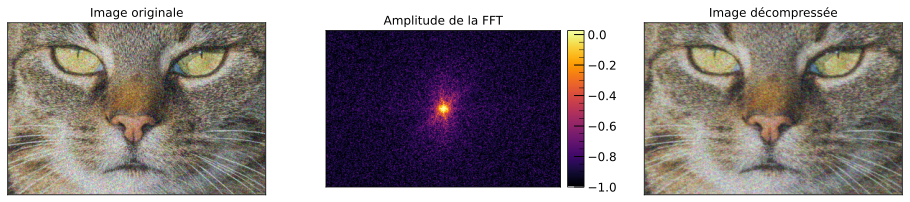

In [5]:
def fft_compressor(
    image: NDArray,
    ratio: float = 0.1,
    reverse: bool = False,
    debug: bool = False,
) -> tuple[NDArray]:
    """Compression d'image via la méthode de la FFT.

    Paramètres
    ----------
        image
            Image d'entrée.
        ratio
            Valeur de seuil pour la compression. Par défaut : 0.1.
        reverse
            Décompresse l'image d'entrée si vrai, sinon compresse l'image.
            Active la compression par défaut.
        debug
            Si vrai, le compresseur retourne également les coefficients DCT
            et le ratio de compression calculé d'après la quantité de donnée
            restante à des fins de vérification.

    Retourne
    --------
        decompr_fft
            Image de transformée de Fourier décompressée.
        compr_fft_mag
            Amplitude de l'image de transformée de Fourier compressée.
        compr_ratio
            Ratio de compression.

    """
    if reverse is False:
        if image.ndim == 3:
            # Applique la FFT sur les canaux du dernier axe
            fft_img = np.fft.fftshift(np.fft.fft2(image, axes=(0, 1)), axes=(0, 1))
        else:
            fft_img = np.fft.fftshift(np.fft.fft2(image))

        # Calculer le seuil basé sur le quantile de l'amplitude
        mag = np.abs(fft_img)
        seuil = np.quantile(mag, 1 - ratio)

        # Tronquer les coefficients de fréquence les moins significatifs
        sig = mag > seuil
        cfft = fft_img * sig
        if debug is True:
            cratio = sig.sum() / np.prod(sig.shape)

            # FFT compressée sur échelle log pour visualisation
            sinf = np.finfo(np.float64).tiny
            cfft_mag = np.log(np.abs(cfft) + sinf)
            cfft_mag /= np.abs(cfft_mag).max()
            return cfft, cfft_mag, cratio
        return cfft

    else:
        # Décompression de l'image
        if image.ndim > 2:
            # Couleur
            dcishift = np.fft.ifftshift(image, axes=(0, 1))
            dcfft = np.fft.ifft2(dcishift, axes=(0, 1)).real
        else:
            # Niveaux de gris
            dcfft = np.fft.ifft2(np.fft.ifftshift(image)).real
        if dcfft.ndim == 3:
            dcfft = np.clip(dcfft, 0, 255).astype(np.uint8)
        return dcfft


# Compression, décompression de l'image score de similitude
cfft, cfft_mag, cratio = fft_compressor(img, debug=True)
dcfft = fft_compressor(cfft, reverse=True)

# Tronquer les données pour la visualisation matplotlib
dcfft = np.round(dcfft).clip(0, 255).astype(np.uint8)
ssim = get_metrics(img, dcfft)

# Résultats
print(f"Taux de compression : {cratio:.2f}")
print(f"Taille de l'image initiale: {init_mem:.3f} MB")
print(f"Taille de l'image compressée: {cratio * init_mem:.3f} MB")
print(f"Coefficient de similitude structurale de référence : {ssim:.3f}%")

fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Image originale")

if cfft_mag.ndim > 2:
    # Visualiser un seul canal pour les images en couleurs
    cfft_mag = cfft_mag[..., 0]

im = axes[1].imshow(cfft_mag, cmap="inferno")
axes[1].set_title("Amplitude de la FFT")
axes[2].imshow(dcfft, cmap="gray")
axes[2].set_title("Image décompressée")

cax = make_axes_locatable(axes[1]).append_axes("right", size="7%", pad="3%")
cbar = fig.colorbar(im, cax=cax)
for n, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(pad=2)
plt.show()

# Décomposition d'images en valeurs singulières (SVD) [3]

La décomposition en valeurs singulières (SVD) est une technique d'algèbre linéaire qui décompose une matrice en trois autres matrices, révélant des propriétés fondamentales de la matrice originale. Pour une image, qui peut être représentée comme une matrice où chaque élément représente l'intensité d'un pixel, la SVD découpe cette matrice en composants qui révèlent des structures importantes de l'image. Les valeurs singulières dans $\Sigma$ donnent une indication de la quantité d'information portée par les vecteurs singuliers correspondants. Dans le contexte d'une image, les premières valeurs singulières (les plus grandes) capturent les caractéristiques les plus significatives de l'image, tandis que les valeurs singulières plus petites peuvent être associées à des détails fins ou du bruit. Soit $A$ une matrice de dimensions $m \times n$, représentant une image en niveaux de gris. La SVD de $A$ s'écrit comme suit:

$$A = U \Sigma V^T$$

où:
- $U$ est une matrice $m \times m$ orthogonale contenant les vecteurs propres de $AA^T$. Ces vecteurs sont appelés vecteurs singuliers à gauche.
- $\Sigma$ est une matrice diagonale $m \times n$ avec des valeurs non négatives sur la diagonale, appelées valeurs singulières. Elles sont triées par ordre décroissant et mesurent l'importance ou le "poids" de chaque vecteur singulier.
- $V^T$ est la transposée d'une matrice $n \times n$ orthogonale contenant les vecteurs propres de $A^TA$. Ces vecteurs sont appelés vecteurs singuliers à droite.

## Compression d'image

La SVD permet de réaliser une compression d'image efficace. En conservant uniquement les $k$ premières valeurs singulières et les colonnes correspondantes de $U$ et $V$, on peut obtenir une approximation de rang $k$ de $A$:
$$A_k = U_k \Sigma_k V_k^T$$

où $U_k$, $\Sigma_k$, et $V_k^T$ contiennent respectivement les $k$ premières colonnes, les $k$ premières valeurs singulières, et les $k$ premières lignes de $V^T$. Cette approximation de bas rang minimise l'erreur quadratique entre la matrice originale et sa version compressée, par rapport à toute autre approximation de même rang.

In [6]:
@njit(fastmath=True, nogil=True)
def svd_compressor(
    image: NDArray,
    k: Optional[int] = None,
) -> NDArray:
    """Décomposition en valeurs singulières (SVD) de la matrice A.

    Paramètres
    ----------
        A
            Matrice à décomposer.
        k
            Nombre de valeurs singulières à garder. Si aucune valeur
            n'est passée, retourne la quantité d'information contenue
            dans chacune des valeur singulière.

    Retourne
    --------
        compr_image
            Approximation de l'image compressée.

    """
    # Ajustements pour la compatibilité avec Numba
    image = image.astype(np.float64)
    image = np.ascontiguousarray(image)

    # Calculer les valeurs propres et vecteurs propres de A^T @ A ou A @ A^T
    m, n = image.shape
    if m >= n:
        eigs, V = np.linalg.eigh(image.T.dot(image))
    else:
        eigs, U = np.linalg.eigh(image.dot(image.T))

    # Assurer que les valeurs propres sont non négatives
    eigs = np.maximum(eigs, 0)

    # Trier les valeurs propres dans l'ordre décroissant
    sort_idx = np.flip(np.argsort(eigs))
    S = np.sqrt(eigs[sort_idx])
    if m >= n:
        V = V[:, sort_idx]
    else:
        U = U[:, sort_idx]

    # Retirer les petites valeurs négatives dues aux erreurs numériques
    S = np.maximum(S, 0)
    nz_mask = S > np.finfo(np.float64).eps * max(image.shape)
    S_nz = S[nz_mask]

    # Calculer les matrices U et V en utilisant les valeurs propres triées
    if m >= n:
        V_nz = np.ascontiguousarray(V[:, nz_mask])
        U = image.dot(V_nz) / S_nz
    else:
        U_nz = np.ascontiguousarray(U[:, nz_mask])
        V = image.T.dot(U_nz) / S_nz

    # Réduire les matrices U et V
    U, V = U[:, :min(m, n)], V[:, :min(m, n)]

    if k is None:
        cum_var = np.atleast_2d(S**2 / np.sum(S**2))
        return cum_var

    # Matrices tronquées
    U_k = np.ascontiguousarray(U[:, :k])
    S_k = np.ascontiguousarray(np.diag(S[:k]))
    Vt_k = np.ascontiguousarray(V.T[:k])

    # Reconstruction de l'image
    compr_image = U_k.dot(S_k).dot(Vt_k)
    return compr_image

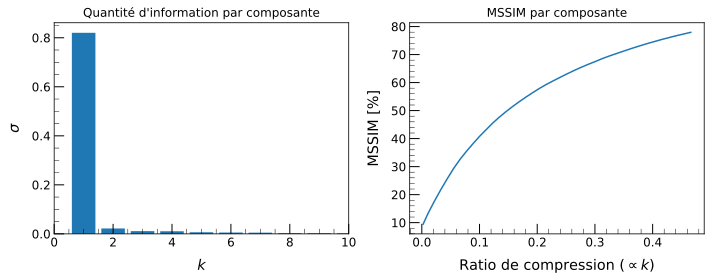

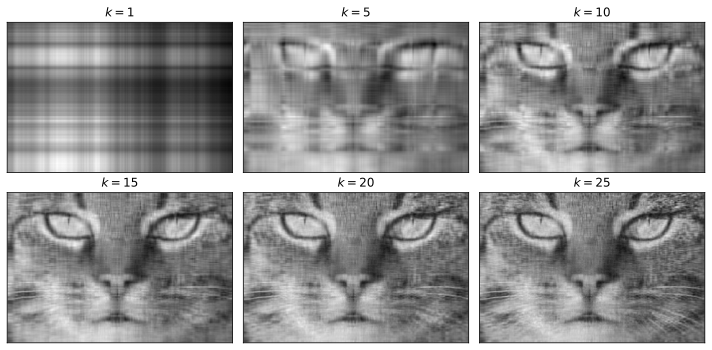

In [7]:
k = np.arange(1, 200, 5)    # Nombre de valeur singulière à garder
k[1:] -= 1                  # Garder des multiples de 5 sauf à k=1
k_vis = k[:5]               # On visualise les 5 premières figures

# Calculer le taux de compression
celements = M * k + k**2 + k * N
cratio = celements / (M * N)

if img.ndim > 2:
    # On visualise un seul canal de couleur
    svd_img = gray_img.copy()
else:
    svd_img = img.copy()

_svd_compress = partial(svd_compressor, svd_img)
_get_metrics = partial(get_metrics, svd_img)
recon = tuple(map(_svd_compress, k))
score = map(_get_metrics, recon)
score = np.asarray([*score], dtype=np.float16)

# Facteurs de performances en fonction des composantes
hist = svd_compressor(svd_img).ravel()
n = np.arange(1, hist.size + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(n, hist)
ax1.set_xlabel("$k$")
ax1.set_ylabel("$\\sigma$")
ax1.set_title("Quantité d'information par composante")
ax1.set_xlim((0, 10))

ax2.plot(cratio, score)
ax2.set_xlabel("Ratio de compression ($\\propto k$)")
ax2.set_ylabel("MSSIM [%]")
ax2.set_title("MSSIM par composante")

# Visualisation des images en fonction des composantes
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for n, ax in enumerate(axes.flat):
    ax.imshow(recon[n], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"$k = {k[n]}$")

plt.show()

## Calcul des métriques pour l'algorithme de compression SVD

In [8]:
df = pd.DataFrame(score[:20], index=k[:20], columns=["MSSIM [%]"]).T
kw = dict(selector="th, td", props=[("text-align", "center")])
df.style.format(precision=1).set_table_styles([kw])

# Espaces colorimétriques et compression d'images

---

Dans le domaine de la compression d'images, la manipulation des espaces colorimétriques jouent un rôle crucial. Les espaces colorimétriques, comme YCbCr et RGB, sont essentiels pour optimiser le traitement et la transmission des images numériques. La cellule suivante permet de visualiser les transformations entre l'espace RGB, qui est communément utilisé dans les affichages numériques, et l'espace YCbCr, fréquemment employé dans la compression d'image, notamment en raison de sa capacité à séparer l'information de luminance des composantes de chrominance. Cette séparation permet une compression plus efficace en exploitant les limitations de la perception humaine des couleurs. Le code qui suit implémente les transformations entre ces deux espaces, illustre leurs différences et comment elles peuvent être manipulées et compressées pour différentes applications en traitement d'image.


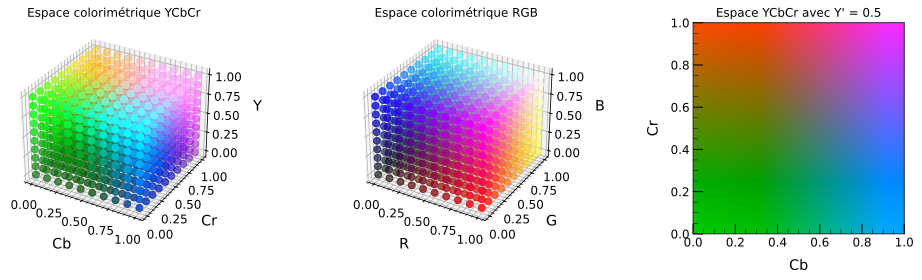

In [9]:
# Matrices de transformation des palettes de couleurs
# Standard BT.2020 pour YCbCr <--> RGB
ycbcr_from_rgb = np.asarray(
    (
        (0.2627, 0.678, 0.0593),
        (-0.13963006, -0.36036994, 0.5),
        (0.5, -0.4597857, -0.0402143),
    )
)
rgb_from_ycbcr = np.linalg.inv(ycbcr_from_rgb)


def color_conv(image, gen=False, to_ycbcr=False, clip: bool = True):
    """Conversion entre les espace colorimétriques RGB et YCbCr.

    Paramètres
    ----------
        image
            Image d'entrée.
        gen
            Flag to generate output suitable for visualization (scaled to [0, 1]).
        to_ycbcr
            Si Vrai, converti de RGB à YCbCr. Converti de YCbCr à RGB
            autrement.

    Retours
    -------
        image
            Image convertie à l'espace colorimétrique spécifiée.

    """
    image = image.copy()
    shift = np.asarray((0, 128, 128))
    scale = np.asarray((219, 224, 224), dtype=np.uint8)
    if to_ycbcr is True:
        # Matrice de transformation de RGB à YCbCr
        t_mat = ycbcr_from_rgb
        if gen:
            image = (image * scale).dot(t_mat.T) + shift
            image = image.clip(0, 255)
        else:
            image = image @ t_mat.T + shift
            if clip is True:
                image = np.clip(image, 0, 255).astype(np.uint8, copy=False)
    else:
        # Matrice de transformation de YCbCr à RGB
        t_mat = rgb_from_ycbcr
        if gen:
            image = (image * scale - shift) @ t_mat.T

            # Les couleurs type float doivent être dans [0, 1] pour matplotlib
            image = np.clip(image / 255, 0, 1)
        else:
            image = (image - shift) @ t_mat.T
            if clip is True:
                image = image.clip(0, 255).astype(np.uint8, copy=False)

    return image


# Création d'une grille 3D
kw = dict(projection="3d")
fig, axes = plt.subplots(1, 3, figsize=(14, 4), subplot_kw=kw)
space = np.linspace(0, 1, 10, dtype=np.float16)
grid = np.meshgrid(space, space, space)

# YCbCr
Y, Cb, Cr = grid
ycbcr = np.stack((Y, Cb, Cr), axis=-1)
RGB = color_conv(ycbcr, gen=True).reshape(-1, 3)
axes[0].scatter(Cb.ravel(), Cr.ravel(), Y.ravel(), c=RGB, s=50)
axes[0].set_xlabel("Cb")
axes[0].set_ylabel("Cr")
axes[0].set_zlabel("Y")
axes[0].set_title("Espace colorimétrique YCbCr")

# RGB
R, G, B = grid
color = np.stack((R, G, B), axis=-1).reshape(-1, 3)
axes[1].scatter(R.ravel(), G.ravel(), B.ravel(), c=color, s=50)
axes[1].set_xlabel("R")
axes[1].set_ylabel("G")
axes[1].set_zlabel("B")
axes[1].set_title("Espace colorimétrique RGB")

# YCbCr avec Y' fixe
luma = 0.5
space = np.linspace(0, 1, 100, dtype=np.float16)
Cb_plane, Cr_plane = np.meshgrid(space, space)
Y_plane = np.full(Cb_plane.shape, luma)
ycbcr = np.stack((Y_plane, Cb_plane, Cr_plane), axis=-1)
RGB = color_conv(ycbcr, gen=True)
axes[2].remove()
axes[2] = fig.add_subplot(133)
axes[2].imshow(RGB, extent=[0, 1, 0, 1], origin="lower")
axes[2].set_xlabel("Cb")
axes[2].set_ylabel("Cr")
axes[2].set_title(f"Espace YCbCr avec Y' = {luma}")

plt.show()

La dernière figure (droite) vise à visualiser comment les variations des composantes de chrominance (Cb et Cr) influencent la couleur perçue, tout en gardant la luminance constante. En fixant Y' (luminance), la figure illustre clairement comment les seules variations de Cb et Cr modifient les couleurs perçues. Cela met en lumière l'importance des composantes de chrominance dans l'espace YCbCr, surtout en ce qui concerne leur rôle dans la perception de couleur sans changer la luminosité. Toutefois, les composantes de chrominance peuvent être sous-échantillonnées plus agressivement (réduites en résolution) sans affecter autant la qualité visuelle perçue, en exploitant la sensibilité moindre de l'œil humain aux détails de couleur par rapport aux variations de luminosité.

## Séparation des canaux de couleurs

---

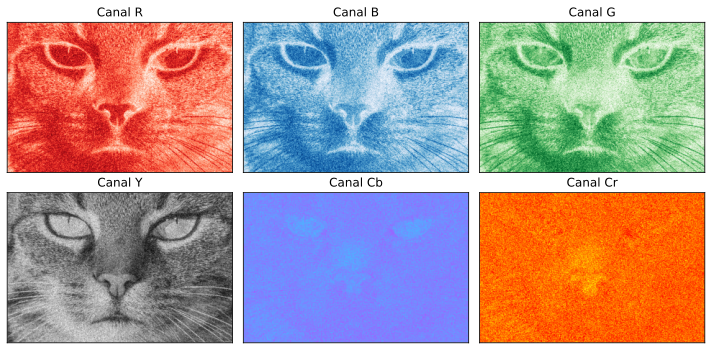

In [10]:
if img.ndim > 2:
    ycbcr_image = color_conv(img, to_ycbcr=True)
    fig, axes = plt.subplots(2, 3, figsize=(10, 5))
    titles = "R", "B", "G", "Y", "Cb", "Cr"
    cmaps = "Reds", "Blues", "Greens", "gray", "cool", "hot"
    for n, ax in enumerate(axes.flat):
        ax.set_title(f"Canal {titles[n]}")
        ax.set_xticks([])
        ax.set_yticks([])
        if n <= 2:
            ax.imshow(img[..., n], cmap=cmaps[n])
        else:
            ax.imshow(ycbcr_image[..., n - 3], cmap=cmaps[n])

    plt.show()

## Compression Colorimétrique [4]

---

### Sous-échantillonnage Chromatique
Une méthode courante de compression colorimétrique consiste à utiliser le sous-échantillonnage chromatique. Comme la vision humaine est moins sensible aux variations de couleur qu'aux variations de luminance, on peut réduire la résolution des canaux de chrominance ($Cb$ et $Cr$ dans $YC_bC_r$) tout en maintenant la résité de la composante de luminance $Y$. Des schémas courants de sous-échantillonnage incluent 4:2:2 et 4:2:0, où le premier chiffre représente le nombre d'échantillons de luminance et les deux autres représentent la quantité relative d'informations de chrominance.

### Quantification
La quantification réduit le nombre de bits utilisés pour représenter une couleur en diminuant la précision des composantes de couleur. Cela peut être réalisé sans perte significative de qualité perceptible grâce à la création de palettes de couleurs optimisées ou par l'ajustement dynamique du nombre de bits par canal selon la variance de couleur dans l'image.

### Ajustements de Couleurs
Certains ajustements de couleurs peuvent être appliqués pour préserver l'apparence de l'image tout en facilitant une compression plus efficace :
- **Balancement des Blancs** : en ajustant les intensités de RGB pour que les objets qui devraient être perçus comme blancs le soient effectivement, ce qui peut rendre l'image plus naturelle après la compression.
- **Contraste et Luminosité** : en optimisant le contraste et la luminosité, on peut réduire la dynamique des couleurs, ce qui peut rendre la compression moins destructrice.

Ratio de compression : 0.50
Coefficient de similitude structurale de référence : 55.295%


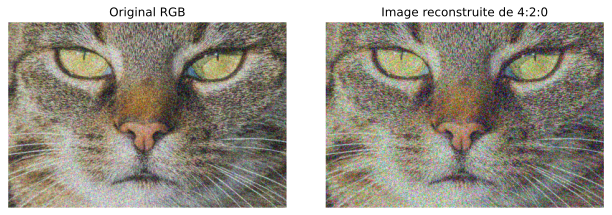

In [11]:
def rebuild(image: NDArray, factor: int = 2) -> NDArray:
    """Reconstruit une image à partir d'une image sous-échantillonnée.

    Le canal Y est pleinement échantillonné, et les canaux Cb et Cr sont intégrés
    à résolution réduite dans le même tableau.

    Paramètres
    ----------
        sub_image
            L'images qui comprend Y pleinement échantillonné et Cb, Cr
            sous-échantillonnés. Cette image doit avoir les dimensions
            (hauteur, largeur, 3), où le canal Y est à l'index 0, et les canaux Cb
            et Cr sous-échantillonnés sont placés aux positions spécifiées par le
            facteur d'échantillonnage dans les canaux 1 et 2, respectivement.
        factor
            Le facteur par lequel les canaux Cb et Cr ont été sous-échantillonnés
            (par exemple, 2 pour le sous-échantillonnage 4:2:0).

    Retourne
    --------
        rgb_full
            L'image RGB reconstituée en pleine résolution.

    """
    sub_image = image.copy()

    # Traitement en cas d'image en nuances de gris
    if sub_image.ndim in (2, 4) or sub_image.shape[-1] == 1:
        return sub_image

    # Extraire les canaux Cb et Cr sous-échantillonnés
    Y = sub_image[..., 0]  # Canal Y en pleine résolution

    height, width = Y.shape[:2]
    Cb_sub = sub_image[..., ::factor, ::factor, 1]
    Cr_sub = sub_image[..., ::factor, ::factor, 2]

    # Create upsample matrices
    upsample_matrix = np.ones((factor, factor))

    # Suréchantillonner Cb et Cr à la pleine résolution via le produit de Kronecker
    Cb_full = np.kron(Cb_sub, upsample_matrix)
    Cr_full = np.kron(Cr_sub, upsample_matrix)

    # S'assurer que les suréchantillonnage correspondent à la taille de Y
    Cb_full = Cb_full[:height, :width]
    Cr_full = Cr_full[:height, :width]

    # Empiler les canaux pour former l'image YCbCr en pleine résolution
    ycbcr_full = np.stack((Y, Cb_full, Cr_full), axis=-1)

    # Convertir YCbCr en RGB
    rgb_full = color_conv(ycbcr_full)
    return rgb_full


def undersample(img1: NDArray, factor: int = 2, debug: bool = False) -> NDArray:
    """Applique un sous-échantillonnage 4:2:0 à une image.

    Cette fonction convertit l'image en format YCbCr, échantillonne le canal Y
    complètement, et sous-échantillonne les canaux Cb et Cr selon le facteur
    spécifié.

    Paramètres
    ----------
        image
            L'image RGB à sous-échantillonner. L'image doit être en format
            RGB avant la conversion.
        factor
            Le facteur de sous-échantillonnage pour les canaux Cb et Cr.
            Un facteur de 2 réduit la résolution de ces canaux par quatre
            (sous-échantillonnage 4:2:0).
        debug
            Retourne le ratio de compression si vrai.

    Retourne
    --------
        rgb_sub
            Tableau numpy en format YCbCr où le canal Y est pleinement échantillonné
            et les canaux Cb et Cr sont sous-échantillonnés, stockés à une résolution
            réduite.

    """
    image = img1.copy()
    if factor == 1:
        return image  # Aucun sous-échantillonnage n'est nécessaire

    # Traitement en cas d'image en nuances de gris
    if image.ndim in (2, 4) or image.shape[-1] == 1:
        if debug is True:
            return image, 1
        return image

    # Convertir RGB à YCbCr
    ycbcr = color_conv(image, to_ycbcr=True)

    # Création d'un tableau de sortie ayant la même hauteur et largeur que Y
    rgb_sub = np.empty_like(ycbcr)
    Y, Cb, Cr = ycbcr[..., 0], ycbcr[..., 1], ycbcr[..., 2]

    # Sous-échantillonnage des canaux Cb et Cr
    Cb_sub = Cb[::factor, ::factor]
    Cr_sub = Cr[::factor, ::factor]

    # Intégration des canaux Y, Cb et Cr sous-échantillonnés à une résolution réduite
    rgb_sub[..., 0] = Y
    rgb_sub[::factor, ::factor, 1] = Cb_sub
    rgb_sub[::factor, ::factor, 2] = Cr_sub

    if debug is True:
        cratio = (Y.size + Cb_sub.size + Cr_sub.size) / image.size
        return rgb_sub, cratio
    return rgb_sub


if img.ndim == 2 or img.shape[-1] == 1:
    print("Pas de sous-échantilonnage pour une image en niveaux de gris")
else:
    # Sous-échantillonnage 4:2:0
    rgb_sub, cratio = undersample(img, factor=2, debug=True)
    rgb_up = rebuild(rgb_sub, factor=2)
    ssim = get_metrics(img, rgb_up)
    print(f"Ratio de compression : {cratio:.2f}")
    print(f"Coefficient de similitude structurale de référence : {ssim:.3f}%")

    # Afficher l'image RGB originale et sous-échantillonnée
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original RGB")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Image reconstruite de 4:2:0")
    plt.imshow(rgb_up)
    plt.axis("off")
    plt.show()

## Quantification des Matrices pour la Compression JPEG [5]

### Introduction à la Quantification
La quantification est une étape dans la compression qui permet de réduire le nombre de bits nécessaires pour stocker une image. Elle fonctionne en simplifiant les valeurs des coefficients de transformée obtenues par DCT (ou autres méthodes), réduisant ainsi la précision mais conservant l'essentiel de l'information visuelle.

### Processus de Quantification
1. **Application de la DCT** : L'image est d'abord divisée en blocs de 8 x 8 pixels, et la DCT est appliquée à chaque bloc. La DCT aide à séparer l'image en parties de fréquences différentes.

2. **Quantification des Coefficients DCT** :
   Chaque coefficient DCT est divisé par un coefficient de quantification correspondant, qui est déterminé par une table de quantification JPEG standard ou personnalisée. Ce coefficient contrôle le niveau de compression et de perte de qualité :
   $$B'_{i,j} = \text{round}\left(\frac{B_{i,j}}{Q_{i,j}}\right)$$

   où $B_{i,j}$ est le coefficient DCT du bloc, $Q_{i,j}$ est le coefficient de la table de quantification pour la position $(i, j)$, et $B'_{i,j}$ est le coefficient quantifié.

3. **Table de Quantification** :
   Les tables de quantification varient la quantité de compression en utilisant des valeurs plus grandes pour une compression plus forte (moins de précision) et des valeurs plus petites pour moins de compression. Ces tables sont souvent optimisées pour la perception humaine, réduisant davantage les fréquences où l'œil est moins sensible.

### Effets de la Quantification
La quantification réduit le nombre de valeurs distinctes que les coefficients DCT peuvent prendre, ce qui simplifie grandement le stockage et la transmission des données. Cependant, cela peut aussi entraîner une perte de qualité d'image, notamment dans les zones de détail élevé ou à fort contraste.

In [12]:
# Table de quantification de la luminance et chrominance
QTY = np.asarray(
    (
        (16, 11, 10, 16, 24, 40, 51, 61),
        (12, 12, 14, 19, 26, 48, 60, 55),
        (14, 13, 16, 24, 40, 57, 69, 56),
        (14, 17, 22, 29, 51, 87, 80, 62),
        (18, 22, 37, 56, 68, 109, 103, 77),
        (24, 35, 55, 64, 81, 104, 113, 92),
        (49, 64, 78, 87, 103, 121, 120, 101),
        (72, 92, 95, 98, 112, 100, 103, 99),
    ),
    dtype=np.uint8,
)
QTC = np.asarray(
    (
        (17, 18, 24, 47, 99, 99, 99, 99),
        (18, 21, 26, 66, 99, 99, 99, 99),
        (24, 26, 56, 99, 99, 99, 99, 99),
        (47, 66, 99, 99, 99, 99, 99, 99),
        (99, 99, 99, 99, 99, 99, 99, 99),
        (99, 99, 99, 99, 99, 99, 99, 99),
        (99, 99, 99, 99, 99, 99, 99, 99),
        (99, 99, 99, 99, 99, 99, 99, 99),
    ),
    dtype=np.uint8,
)
QT = np.stack((QTY, QTC, QTC), axis=-1)


def zigzag(matrix: NDArray, shape: Optional[tuple] = None) -> NDArray:
    """Calcul de l'ordre zigzag d'une matrice.

    Paramètres
    ----------
        matrix
            La matrice à réordonner.
        shape
            Forme à utiliser si la matrice est fournie comme un tableau
            unidimensionnel.

    Retourne
    --------
        arr
            Tableau unidimensionnel représentant la matrice dans l'ordre zigzag.

    Notes
    -----
        Si 'shape' est spécifié et 'matrix' est un tableau unidimensionnel,
        la matrice est d'abord redimensionnée selon 'shape'. Sinon, 'shape'
        est dérivé de la matrice elle-même.

    """
    if shape is not None and matrix.ndim == 1:
        rows, cols = shape
    else:
        rows, cols = matrix.shape[:2]

    # Obtention des indices de lignes et de colonnes
    idx = np.indices((rows, cols))
    col_idx = idx[1].ravel()

    # Calcul de la somme des indices pour les bandes diagonales
    sum_idx = idx[0].ravel() + col_idx

    # Direction croissante pour les sommes paires, sinon décroissante
    alter_order = np.where(sum_idx % 2 == 0, col_idx, cols - col_idx - 1)

    # Trier les indices en fonction des indices de somme et l'ordre alterné
    sort_indices = np.lexsort((alter_order, sum_idx))

    # Récupération des éléments dans l'ordre trié
    if matrix.ndim != 1:
        arr = matrix.ravel()[sort_indices]
    else:
        arr = np.empty_like(matrix)
        arr[sort_indices] = matrix
        arr = arr.reshape(rows, cols)
    return arr


def split_blocs(image, bsize=(8, 8), stats: bool = False):
    """Découpe l'image en blocs non superposés de taille bsize.

    Gère automatiquement les images monochromes et multichromes
    via la vectorisation d'opérations.

    Paramètres
    ----------
        image
            Image d'entrée monochrome ou multichrome.
        bsize
            Tuple spécifiant la taille de chaque bloc (hauteur, largeur).

    Retourne
    --------
        blocs
            Tableau numpy 4D ou 5D : blocs indexés comme
            (nby, nbx, bh, bw) pour le niveau de gris ou
            (nby, nbx, bh, bw, num_channels) pour la couleur.

    """
    bh, bw = bsize
    h, w = image.shape[:2]

    # Rendre l'image un multiple de la taille du bloc
    h_pad = (bh - h % bh) % bh
    w_pad = (bw - w % bw) % bw

    # Pad l'image si nécessaire, pour la hauteur et la largeur uniquement
    pad = ((0, h_pad), (0, w_pad)) + ((0, 0),) * (image.ndim - 2)
    pad_img = np.pad(image, pad, mode="constant", constant_values=0)

    # Remodeler l'image remplie pour séparer les blocs
    h_shape = (h + h_pad) // bh
    w_shape = (w + w_pad) // bw
    pad_img = pad_img.reshape((h_shape, bh, w_shape, bw) + image.shape[2:])

    # Réorganiser les dimensions pour l'indexation des blocs
    if image.ndim == 2:
        # Niveaux de gris
        blocs = pad_img.transpose(0, 2, 1, 3)
    else:
        # Couleur
        blocs = pad_img.transpose(0, 2, 1, 3, 4)

    if stats is True:
        return blocs, bh, bw, h_shape, w_shape
    return blocs


def merge_blocs(blocs: NDArray) -> NDArray:
    """Reconstruit une image à partir des blocs 8x8.

    Paramètres
    ----------
        blocs
            Tableau numpy de blocs d'images, obtenus à partir de la
            fonction 'split_blocs'.

    Retourne
    --------
        image
            Image reconstituée à partir des blocs.

    """
    if blocs.ndim == 4:
        # Niveaux de gris
        h_shape, w_shape, bh, bw = blocs.shape
        h_blocs, w_blocs = h_shape * bh, w_shape * bw
        image = blocs.transpose(0, 2, 1, 3).reshape(h_blocs, w_blocs)
    else:
        # Couleur
        h_shape, w_shape, bh, bw, n_chan = blocs.shape
        h_blocs, w_blocs = h_shape * bh, w_shape * bw
        image = blocs.transpose(0, 2, 1, 3, 4).reshape(h_blocs, w_blocs, n_chan)
    return image


def quantize_blocks(blocks: NDArray, dquant: bool = False) -> NDArray:
    """Quantifie ou déquantifie des blocs d'une image.

    Paramètres
    ----------
        blocks
            Blocs de l'image.
        dquant
            Déquantification si vrai, quantification si faux.

    Retourne
    --------
        q_blocks
            Les blocs traités après quantification ou déquantification.

    """
    nbh, nbw = blocks.shape[0], blocks.shape[1]
    if blocks.ndim == 4:
        # Niveaux de gris
        tiled_QT = np.tile(QTY, (nbh, nbw, 1, 1))
    else:
        # Couleurs
        tiled_QT = np.tile(QT, (nbh, nbw, 1, 1, 1))

    if dquant:
        q_blocks = blocks * tiled_QT
    else:
        q_blocks = blocks / tiled_QT
    return q_blocks

## Encodage Huffman pour la Compression JPEG

### Introduction à l'Encodage Huffman
L'encodage Huffman est une technique de compression de données sans perte qui utilise des codes de longueur variable pour représenter les symboles, en fonction de leur fréquence d'occurrence. Les symboles les plus fréquents sont codés avec les chaînes de bits les plus courtes, et les moins fréquents avec les plus longues.

### Processus d'Encodage Huffman
1. **Analyse des Fréquences** : Compter la fréquence de chaque symbole dans les données (dans le cas de JPEG, les symboles peuvent être les coefficients quantifiés).

2. **Construction de l'Arbre Huffman** :
   - Créer un nœud pour chaque symbole et le placer dans une file de priorité basée sur la fréquence.
   - Répéter jusqu'à ce que la file soit vide :
     - Retirer les deux nœuds avec la plus faible fréquence.
     - Fusionner ces nœuds pour former un nouveau nœud dont la fréquence est la somme des deux fréquences.
     - Insérer le nouveau nœud dans la file.

3. **Génération des Codes Huffman** : Assigner un code binaire à chaque symbole en parcourant l'arbre de Huffman, en attribuant un "0" pour aller à gauche et un "1" pour aller à droite.

## Tests d'encodage

In [13]:
import sys
import huffmp

# Test avec une chaine de texte
txt = "Mark Parizeau et Xavier Maldague"
encoded_text, decoded_text, csize = huffmp.process_data(txt)
init_size = 8 * sys.getsizeof(txt)
print(f"Texte original : {txt}")
print(f"Texte encodé : {encoded_text[0]}")
print(f"Text décodé : {decoded_text}")
print(f"Taille initiale : {init_size} B")
print(f"Taille finale : {csize} B")
print(f"Réduction de mémoire : {init_size - csize} B")
print(f"Ratio de compression : {csize / init_size:.4f}\n")

# Test avec un array 2D
np.random.seed(42)
array_data = np.random.rand(3, 3, 5)
encoded_array, decoded_array, csize = huffmp.process_data(array_data)
init_size = 8 * array_data.nbytes
print(f"Array encodé : {encoded_array[0]}")
print(f"Taille initiale : {init_size} B")
print(f"Taille compressée : {csize} B")
print(f"Réduction de mémoire : {init_size - csize} B")
print(f"Ratio de compression : {csize / init_size:.4f}")
print(f"Array original :\n {array_data}")
print(f"Array décodé :\n {decoded_array}")

Texte original : Mark Parizeau et Xavier Maldague
Texte encodé : 01
Text décodé : Ma
Taille initiale : 584 B
Taille finale : 2 B
Réduction de mémoire : 582 B
Ratio de compression : 0.0034

Array encodé : 10011000110100111000100011111101111111010100000011101101011101000011000011011011111110010101001110011110010101111101110101100011111101011000111100111000110101111011101101111100001010010011010000001000001110001110100101101010101010010010100001100111101
Taille initiale : 2880 B
Taille compressée : 251 B
Réduction de mémoire : 2629 B
Ratio de compression : 0.0872
Array original :
 [[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
  [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
  [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]]

 [[0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
  [0.61185289 0.13949386 0.29214465 0.36636184 0.45606998]
  [0.78517596 0.19967378 0.51423444 0.59241457 0.04645041]]

 [[0.60754485 0.17052412 0.06505159 0.94888554 0.96563203

# Méthode de compression mixte

---

## Compression colorimétrique, DCT, quantification et Huffman 

In [14]:
def jpeg2024(image: NDArray, ratio: float) -> NDArray:
    """Implémente un algorithme de compression avec pertes similaire à JPEG.

    La fonction regroupe les méthodes qui ont été présentées
    jusqu'à maintenant.

    Paramètres
    ----------
        image
            L'image à compresser.
        ratio
            Ratio de compression théorique à envoyer au
            compresseur DCT.

    Retourne
    --------
        specs
            Les résultats de la compression et décompression de l'image.

    """
    mem_init = get_memory(image)

    # Étapes de compression
    cconv = undersample(image)
    sb = split_blocs(cconv)
    dcsb = dct_compressor(sb, ratio)
    qb = quantize_blocks(dcsb)

    # Encodage et décodage Huffman
    _, decoded, csize = huffmp.parallel_huffman(qb)

    # Étapes de décompression
    dqb = quantize_blocks(decoded, dquant=True)
    icmb = dct_compressor(dqb, reverse=True)
    dconv = rebuild(icmb)
    recon = merge_blocs(dconv)
    ssim = get_metrics(image, recon)

    # Reconvertir en image 8 bits
    final_image = np.round(recon).astype(np.uint8)

    # Taille de l'objet compressé et ratio de compression réel
    osize = get_memory(qb)
    cratio = csize / mem_init

    # Taille de l'image reconstruite
    decomp_size = get_memory(final_image)
    specs = osize, csize, cratio, decomp_size, ssim, final_image
    return specs

Compression des données avec 28 cœurs CPU...

Taille originale : 21.234 MB
Taille avant Huffman : 169.869 MB
Taille compressée: 11.894 MB
Ratio de compression : 0.5602
Taille décompressée: 21.234 MB
Coefficient de similitude structurale de référence : 33.888%


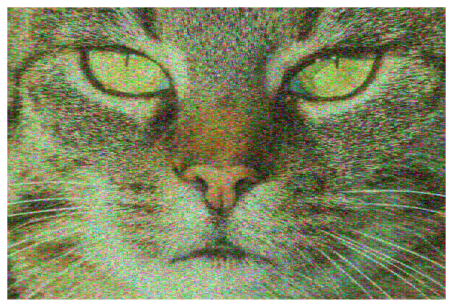

In [15]:
ratio = 0.2
specs = jpeg2024(img, ratio)

# Résultats
print(f"Taille originale : {init_mem:.3f} MB")
print(f"Taille avant Huffman : {specs[0]:.3f} MB")
print(f"Taille compressée: {specs[1]:.3f} MB")
print(f"Ratio de compression : {specs[2]:.4f}")
print(f"Taille décompressée: {specs[3]:.3f} MB")
print(f"Coefficient de similitude structurale de référence : {specs[4]:.3f}%")
plt.imshow(specs[-1], cmap="gray")
plt.axis("off")
plt.show()

Compression des données avec 28 cœurs CPU...

Taille originale : 21.234 MB
Taille avant Huffman : 169.869 MB
Taille compressée: 17.956 MB
Ratio de compression : 0.8457
Taille décompressée: 21.234 MB
Coefficient de similitude structurale de référence : 43.944%


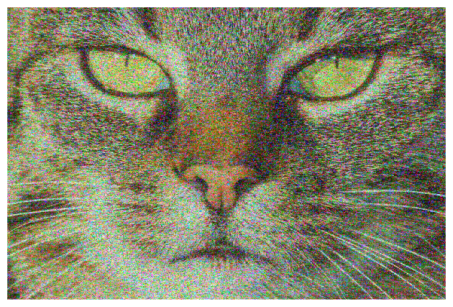

In [16]:
ratio = 0.3
specs = jpeg2024(img, ratio)

# Résultats
print(f"Taille originale : {init_mem:.3f} MB")
print(f"Taille avant Huffman : {specs[0]:.3f} MB")
print(f"Taille compressée: {specs[1]:.3f} MB")
print(f"Ratio de compression : {specs[2]:.4f}")
print(f"Taille décompressée: {specs[3]:.3f} MB")
print(f"Coefficient de similitude structurale de référence : {specs[4]:.3f}%")
plt.imshow(specs[-1], cmap="gray")
plt.axis("off")
plt.show()

Compression des données avec 28 cœurs CPU...



Taille originale : 12.442 MB
Taille avant Huffman : 99.533 MB
Taille compressée: 7.287 MB
Ratio de compression : 0.5857
Taille décompressée: 12.442 MB
Coefficient de similitude structurale de référence : 75.167%


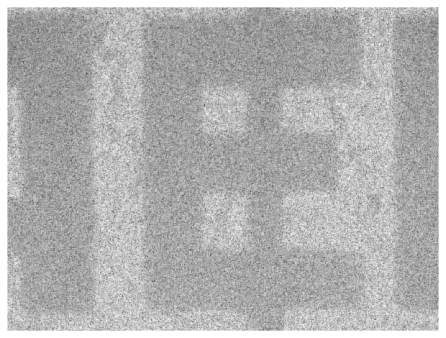

In [17]:
ratio = 0.2
specs = jpeg2024(img_m, ratio)

# Résultats
print(f"Taille originale : {init_mem_m:.3f} MB")
print(f"Taille avant Huffman : {specs[0]:.3f} MB")
print(f"Taille compressée: {specs[1]:.3f} MB")
print(f"Ratio de compression : {specs[2]:.4f}")
print(f"Taille décompressée: {specs[3]:.3f} MB")
print(f"Coefficient de similitude structurale de référence : {specs[4]:.3f}%")
plt.imshow(specs[-1], cmap="gray")
plt.axis("off")
plt.show()

Compression des données avec 28 cœurs CPU...

Taille originale : 55.296 MB
Taille avant Huffman : 442.368 MB
Taille compressée: 43.859 MB
Ratio de compression : 0.7932
Taille décompressée: 55.296 MB
Coefficient de similitude structurale de référence : 96.085%


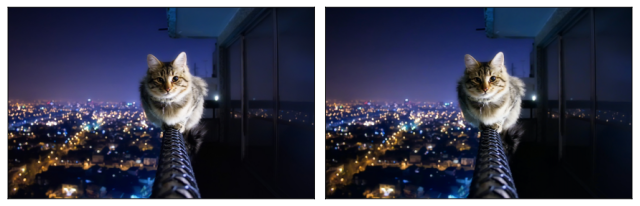

In [18]:
ratio = 0.4
cat = read_file("uncompressed_cat.png")
specs = jpeg2024(cat, ratio)
mem_cat = get_memory(cat)

# Résultats
print(f"Taille originale : {mem_cat:.3f} MB")
print(f"Taille avant Huffman : {specs[0]:.3f} MB")
print(f"Taille compressée: {specs[1]:.3f} MB")
print(f"Ratio de compression : {specs[2]:.4f}")
print(f"Taille décompressée: {specs[3]:.3f} MB")
print(f"Coefficient de similitude structurale de référence : {specs[4]:.3f}%")

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
axes[0].imshow(cat)
axes[1].imshow(specs[-1])
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Références

[1] Zhou Wang *et al*. “Image Quality Assessment: From Error Visibility to Structural Similarity”. *IEEE Transactions on Image Processing*, vol. 13, no. 4, 2004. URL : https://doi.org/10.1109/TIP.2003.819861. Page consultée le 15 avril 2024.
<br><br>
[2] Image Engineering. *How does the JPEG compression work?*. 2011. URL : [JPEG compression](https://www.image-engineering.de/library/technotes/745-how-does-the-jpeg-compression-work#:~:text=The%20JPEG%20compression%20is%20a%20block%20based%20compression.,the%20data%20reduction%20by%20setting%20%28or%20chose%20presets%29.). Page consultée le 20 avril 2024.
<br><br>
[3] Jagdeesh. *Singular Value Decomposition – A Comprehensive guide on Singular Value Decomposition*. Machine Learning +. URL : https://www.machinelearningplus.com/linear-algebra/singular-value-decomposition. Page consultée le 17 avril 2024.
<br><br>
[4] *Recommandation UIT-R BT.2020-2: Valeurs de paramètres des systèmes de télévision à ultra haute définition pour la production et l'échange international de programmes*. UIT-R, 2020. URL : https://www.itu.int/dms_pubrec/itu-r/rec/bt/R-REC-BT.2020-2-201510-I!!PDF-F.pdf. Page consultée le 18 avril 2024.
<br><br>
[5] *Huffman Coding*. programiz. URL : https://www.programiz.com/dsa/huffman-coding. Page consultée le 24 avril 2024.